# Short Tank Geometry and Event Plotting of CNN mPMT Dataset

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import torch
import copy

In [5]:
sys.path.append('/home/lbidulka')
sys.path.append('/home/lbidulka/WatChMaL')

In [6]:
import WatChMaL.analysis.event_utils as ev
from WatChMaL.analysis.event_analysis.EventPlotter import EventPlotter
from watchmal.dataset.cnn_mpmt.cnn_mpmt_dataset import CNNmPMTDataset

In [7]:
def channel_to_position(channel):
    channel = channel % 19 
    theta = (channel<12)*2*np.pi*channel/12 + ((channel >= 12) & (channel<18))*2*np.pi*(channel-12)/6
    radius = 0.2*(channel<18)+0.2*(channel<12)
    position = [radius*np.cos(theta), radius*np.sin(theta)] # note this is [y, x] or [row, column]
    return position

In [8]:
def plot_event(data, mpmt_pos, old_convention=False, title=None, style="default", cmap=plt.cm.jet):
    cmap = copy.copy(cmap)
    if style=="dark_background":
        edgecolor='0.15'
        cmap.set_bad(color='black')
    else:
        edgecolor='0.85'
        cmap.set_bad(color='white')
    data[data==0] = np.nan
    indices = np.indices(data.shape)
    channels = indices[0].flatten()
    positions = indices[1:].reshape(2,-1).astype(np.float64)
    positions += channel_to_position(channels)
    if old_convention:
        positions[1] = max(mpmt_pos[:, 1])-positions[1]
    mpmts = [Circle((pos[1], pos[0]), radius=0.47)
             for pos in mpmt_pos]
    with plt.style.context(style):
        if old_convention:
            figsize = (20,16)
        else:
            figsize = (20,12)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.add_collection(PatchCollection(mpmts, facecolor='none', linewidths=1, edgecolors=edgecolor))
        pmts = ax.scatter(positions[1], positions[0], c=data.flatten(), s=3, cmap=cmap)
        cbar = plt.colorbar(pmts)
        cbar.set_label("PMT Charge")
    if title is not None:
        ax.set_title(title)

## Display Short Tank Data

### Load and Plot Short Tank Geometry

In [9]:
geo_path = '/fast_scratch/WatChMaL/data/geometries/geo_mPMTshort.npz'
geofile = np.load(geo_path, allow_pickle=True)

tubes = geofile[ 'tube_no' ]

tube_xyz = geofile[ 'position' ]
tube_x   = tube_xyz[:,0]
tube_y   = tube_xyz[:,1]
tube_z   = tube_xyz[:,2]

R =  (tube_x.max() - tube_x.min())/2.0

tube_dir = geofile[ 'orientation']

Short tank dimensions: 
399.0980529785156
296.4490661621094
399.0980529785156
R:  399.0980529785156


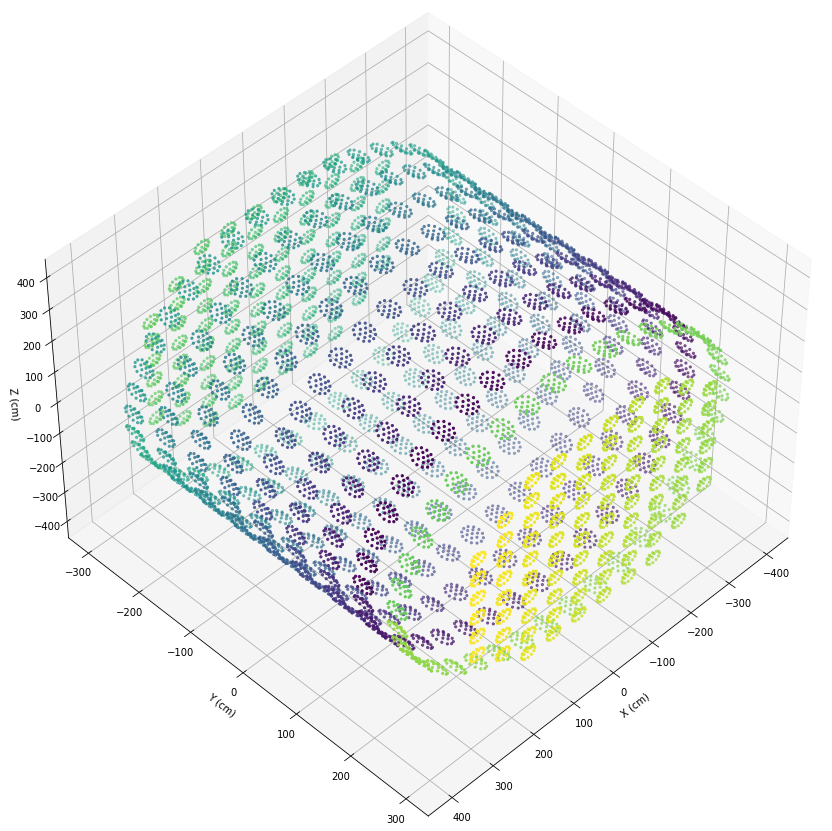

In [10]:
print("Short tank dimensions: ")
print(tube_x.max())
print(tube_y.max())
print(tube_z.max())
print("R: ", R)

fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter( tube_x, tube_y, tube_z, marker='.', c=tubes - 1, cmap=plt.cm.viridis, label='short'  )
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.view_init(elev=45.0, azim=45.0)
plt.show()

<Figure size 432x288 with 0 Axes>

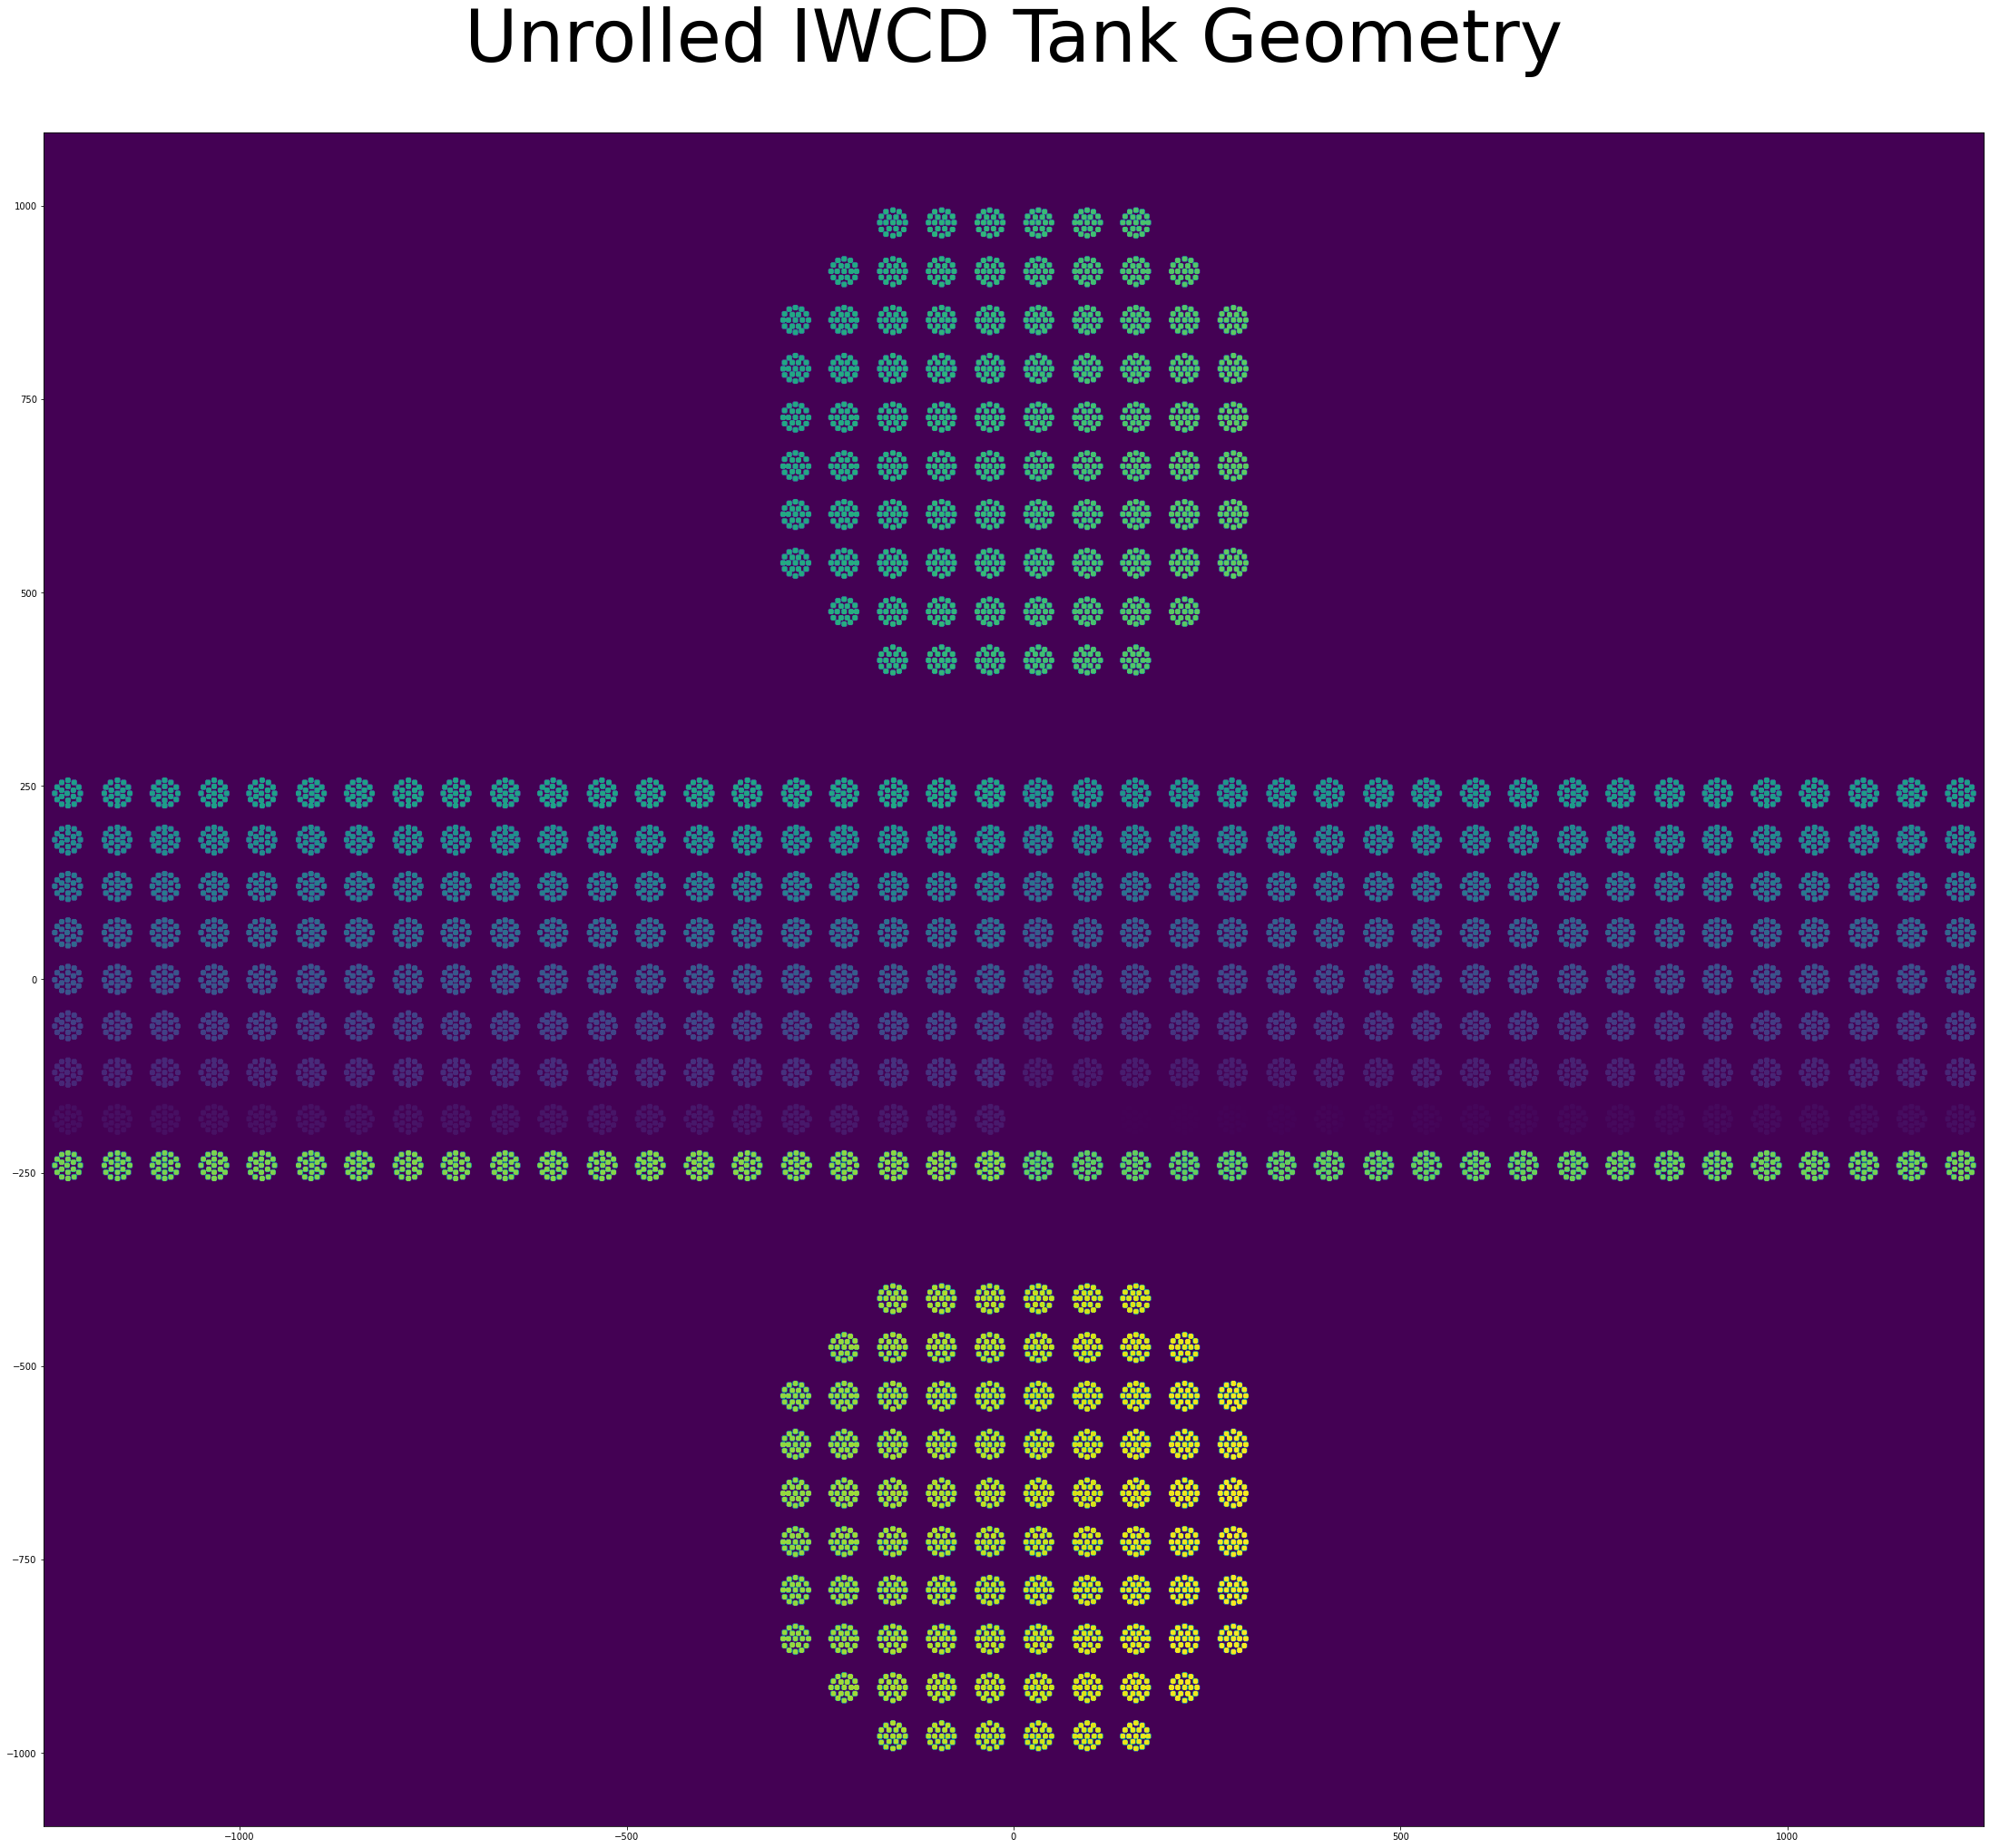

In [11]:
plotter = EventPlotter(h5_path='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5',
                       mpmt_positions_file='/fast_scratch/WatChMaL/data/geometries/IWCDshort_mPMT_image_positions.npz', 
                       geo_path='/fast_scratch/WatChMaL/data/geometries/geo_mPMTshort.npz')
corrected_tubes = tubes - 1

plotter.display_data(corrected_tubes, corrected_tubes, title='Unrolled IWCD Tank Geometry', cmap=plt.cm.viridis, labels=False)

### Loading Data and Plotting Test Event

In [12]:
dataset_short = CNNmPMTDataset(h5file='/fast_scratch/WatChMaL/data/IWCD_mPMT_Short/IWCD_mPMT_Short_emg_E0to1000MeV_digihits.h5',
                         mpmt_positions_file='/fast_scratch/WatChMaL/data/geometries/IWCDshort_mPMT_image_positions.npz',
                         is_distributed=False)

torch.Size([19, 29, 40])


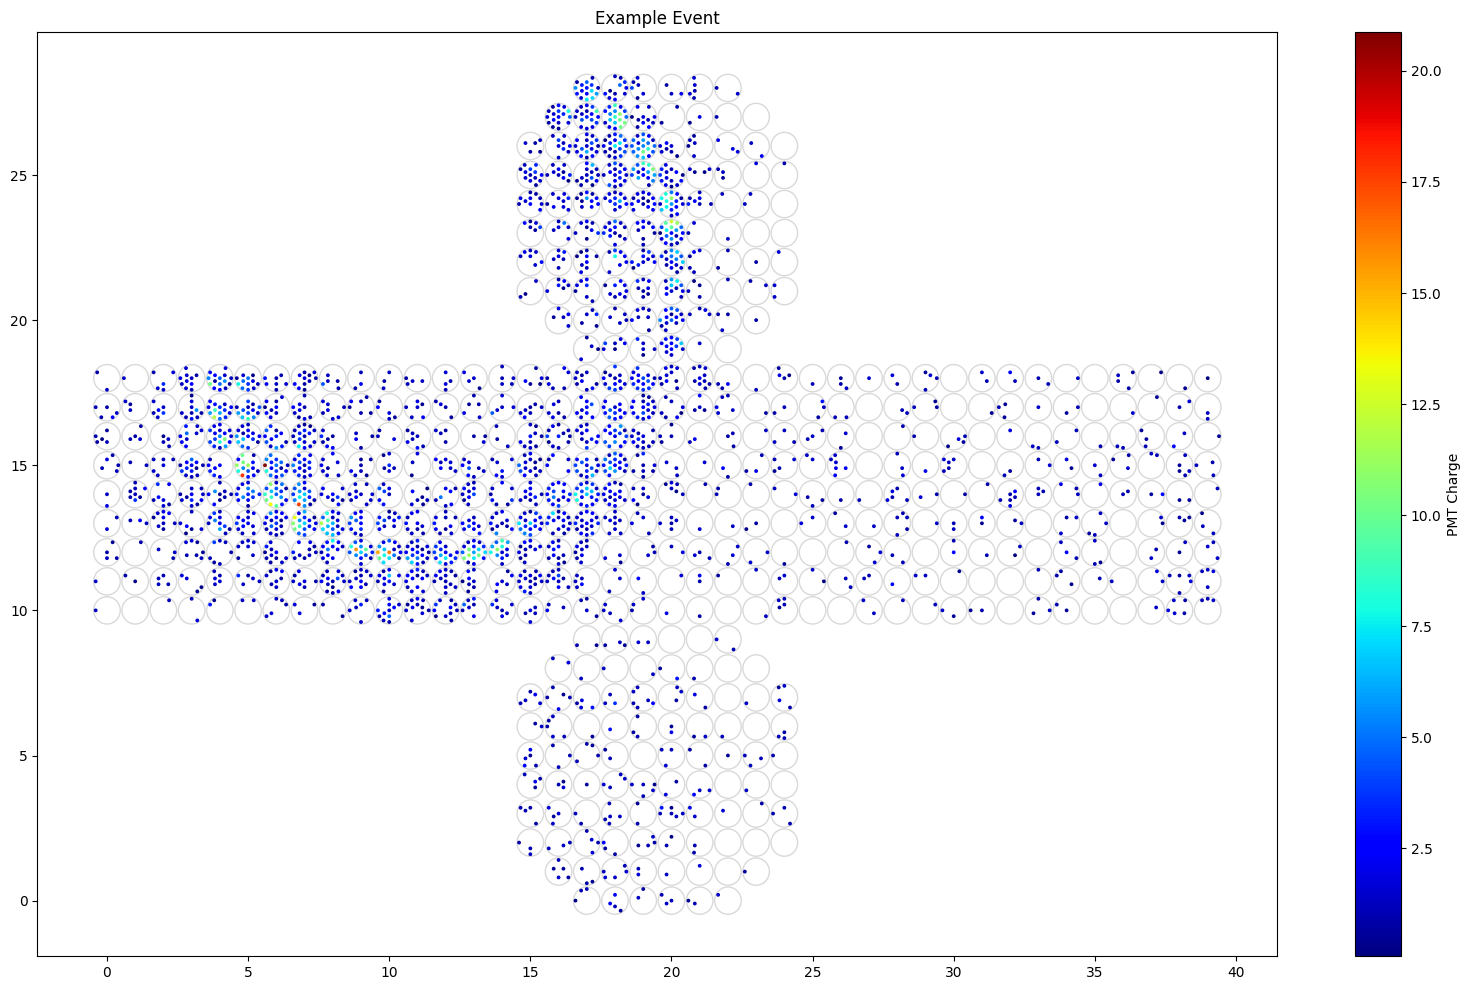

In [13]:
data_short = dataset_short.__getitem__(8)['data']
print(data_short.shape)
plot_event(data_short, dataset_short.mpmt_positions, title="Example Event")